In [1]:
!pip install -q --upgrade scikit-learn pandas matplotlib joblib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 68.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
dask-cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.3 which is incompatible.
cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.3 which is incompatible.


In [2]:
# imports
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns  # optional for nicer plots
import joblib  # to save/load models

In [3]:
iris = datasets.load_iris()
X = iris.data
y = iris.target
print("Features:", iris.feature_names)
print("Target names:", iris.target_names)
print("X shape:", X.shape, "y shape:", y.shape)

df = pd.DataFrame(X, columns=iris.feature_names)
df['target'] = y
df.head()


Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Target names: ['setosa' 'versicolor' 'virginica']
X shape: (150, 4) y shape: (150,)


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (120, 4) Test: (30, 4)


In [5]:
# build a pipeline that scales then fits logistic regression
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=200))
])
pipe.fit(X_train, y_train)

# predict & evaluate
y_pred = pipe.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=iris.target_names))


Accuracy: 0.9333333333333333
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.90      0.90      0.90        10
   virginica       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



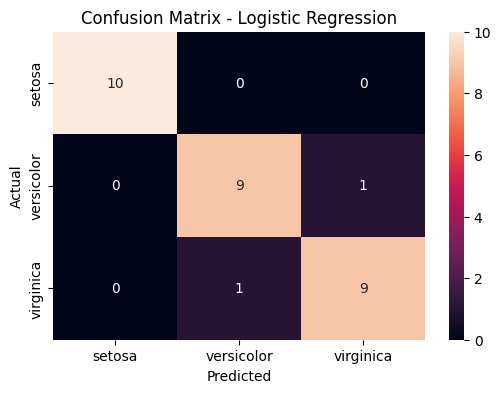

In [6]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=iris.target_names, yticklabels=iris.target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()


In [7]:
scores = cross_val_score(pipe, X, y, cv=5, scoring='accuracy')
print("5-fold CV accuracies:", scores)
print("Mean CV accuracy:", scores.mean())

5-fold CV accuracies: [0.96666667 1.         0.93333333 0.9        1.        ]
Mean CV accuracy: 0.9600000000000002


In [8]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("RF Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, target_names=iris.target_names))

RF Accuracy: 0.9
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.82      0.90      0.86        10
   virginica       0.89      0.80      0.84        10

    accuracy                           0.90        30
   macro avg       0.90      0.90      0.90        30
weighted avg       0.90      0.90      0.90        30



In [9]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000))
])

param_grid = {
    'clf__C': [0.01, 0.1, 1, 10, 100],
    'clf__penalty': ['l2'],  # keep it simple
    'clf__solver': ['lbfgs']
}

grid = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV score:", grid.best_score_)
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
print("Test accuracy (best model):", accuracy_score(y_test, y_pred))

Best params: {'clf__C': 10, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
Best CV score: 0.9666666666666668
Test accuracy (best model): 1.0


In [10]:
# save
joblib.dump(best_model, 'best_iris_model.joblib')

# load
loaded = joblib.load('best_iris_model.joblib')
print("Loaded model test accuracy:", accuracy_score(y_test, loaded.predict(X_test)))

Loaded model test accuracy: 1.0
